<a href="https://colab.research.google.com/github/Johnny880724/AFSA_material/blob/main/fish_on_real_crystal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Mount Google Drive to access your files
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import necessary libraries
import numpy as np

# Step 3: Define the path to your .txt file
# You can find the path after mounting your Google Drive.
# Make sure to adjust the path based on where your file is located in Drive.
file_path = '/content/drive/MyDrive/crystal data/5A_parsed_file.txt'

# Step 4: Load the .txt file into a NumPy array
# Assuming the file is space-separated, but adjust delimiter if needed
matrix = np.loadtxt(file_path)

coordinates = matrix[:, 1:]  # Extract all rows except the first
bounds = np.array([[np.min(coordinates[:, i]), np.max(coordinates[:, i])] for i in range(coordinates.shape[1])])

# Step 6: Display the calculated bounds
print("Calculated Bounds for Each Dimension:")
print(bounds)

# Step 5: Display the matrix

print(np.min(matrix[:, 0]))
print("Matrix Loaded from File:")
print(coordinates[1])


Mounted at /content/drive
Calculated Bounds for Each Dimension:
[[  1.621  84.27 ]
 [-20.     17.93 ]
 [-41.37   42.61 ]
 [  0.      0.   ]
 [  3.215  90.53 ]
 [-23.85  141.7  ]
 [  0.      0.   ]
 [  0.      0.   ]
 [  3.704  66.77 ]]
-153.5799
Matrix Loaded from File:
[ 4.961e+00  6.140e-16 -3.787e+00  0.000e+00  1.864e+01  4.770e-15
  0.000e+00  0.000e+00  6.941e+00]


MultiGaussian fitting

In [2]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def fit_gaussian_process(input_array):
    """
    Fit a Gaussian Process model to the provided n-dimensional array.

    Args:
    - input_array (np.ndarray): The n-dimensional array where the first row contains energy (z-values)
                                and the subsequent rows represent the coordinates in n-dimensional space.

    Returns:
    - gp (GaussianProcessRegressor): The trained Gaussian Process model.
    """
    # Separate the energy (first row) and location data (other rows)
    energy_values = input_array[0, :]  # Energy values (z)
    location_data = input_array[1:, :].T  # Location data (x, y, ...)

    # Define the kernel: we use a product of constant kernel and RBF kernel (Gaussian kernel)
    kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))  # Constant * RBF kernel

    # Initialize the GaussianProcessRegressor with the kernel
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    # Fit the GP model to the data
    gp.fit(location_data, energy_values)

    return gp

def predict_energy(gp, location):
    """
    Predict the energy at a given location using the fitted Gaussian Process model.

    Args:
    - gp (GaussianProcessRegressor): The trained Gaussian Process model.
    - location (np.ndarray): The location for which to predict the energy.

    Returns:
    - energy (float): The predicted energy at the given location.
    """
    # Ensure the location is in the right shape (1 x n_dim)
    location = np.array(location).reshape(1, -1)

    # Use the Gaussian Process model to predict the energy at the specified location
    energy, _ = gp.predict(location, return_std=True)

    return energy[0]  # Return the predicted energy value

# Example Usage:
# Input: An example n-dimensional array where the first row is energy, and others are coordinates.
input_array = np.array([
    [1.0, 2.0, 3.0, 4.0],  # Energy (z-values)
    [0.0, 1.0, 2.0, 3.0],  # Location 1 (x)
    [1.0, 1.5, 2.0, 2.5],  # Location 2 (y)
])

# Fit the Gaussian Process model to the input data
gp_model = fit_gaussian_process(matrix.T)

# Predict the energy at a new location (e.g., at location [2.5, 2.0])
new_location = [12.53040961,-0.35355502,0.77559776,0,3.25126297,-0.71151855,0,0,31.57864638]

predicted_energy = predict_energy(gp_model, new_location)

# Output the predicted energy
print(f"Predicted energy at location {new_location}: {predicted_energy}")


Predicted energy at location [12.53040961, -0.35355502, 0.77559776, 0, 3.25126297, -0.71151855, 0, 0, 31.57864638]: -569.8973307257903


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
#test energy
new_location = [3.403000e+00,7.536000e-01,-5.178000e+00,0.000000e+00,1.902000e+01,-6.320000e+00,0.000000e+00,0.000000e+00,9.908000e+00]

predicted_energy = predict_energy(gp_model, new_location)

print(f"Predicted energy at location {new_location}: {predicted_energy}")

Predicted energy at location [3.403, 0.7536, -5.178, 0.0, 19.02, -6.32, 0.0, 0.0, 9.908]: -153.57989999870267


Fish sworm


In [3]:
import numpy as np

class ArtificialFishSwarm:
    def __init__(self, objective_function, n_dim, bounds, population_size=50, max_iter=100, step_size=0.1, visual_range=0.5):
        self.objective_function = objective_function
        self.n_dim = n_dim
        self.bounds = bounds  # Bounds shape: (n_dim, 2)
        self.population_size = population_size
        self.max_iter = max_iter
        self.step_size = step_size
        self.visual_range = visual_range

        # Initialize population (randomly within bounds)
        self.population = np.random.uniform(
            self.bounds[:, 0], self.bounds[:, 1], (self.population_size, self.n_dim)
        )
        # Fitness values for each fish
        self.fitness = np.array([self.objective_function(ind) for ind in self.population])

        # Global best solution
        self.best_fish = self.population[np.argmin(self.fitness)]
        self.best_fitness = np.min(self.fitness)

    def move_fish(self, fish, target):
        """
        Move a fish towards a target fish within the step size.
        """
        direction = target - fish
        distance = np.linalg.norm(direction)

        if distance > 0:
            direction = direction / distance  # Normalize direction

        # Move the fish in the direction of the target
        new_position = fish + self.step_size * direction

        # Clip the new position to remain within bounds
        return np.clip(new_position, self.bounds[:, 0], self.bounds[:, 1])

    def search_neighborhood(self, fish):
        """
        Search the neighborhood of a fish for a better position.
        """
        best_fish_in_neighborhood = fish
        best_fitness_in_neighborhood = self.objective_function(fish)

        # Randomly explore the neighborhood
        for _ in range(10):  # Arbitrary number of random searches
            random_step = np.random.uniform(-self.visual_range, self.visual_range, self.n_dim)
            candidate_fish = fish + random_step
            candidate_fish = np.clip(candidate_fish, self.bounds[:, 0], self.bounds[:, 1])  # Clip within bounds
            candidate_fitness = self.objective_function(candidate_fish)

            if candidate_fitness < best_fitness_in_neighborhood:
                best_fish_in_neighborhood = candidate_fish
                best_fitness_in_neighborhood = candidate_fitness

        return best_fish_in_neighborhood

    def run(self):
        """
        Run the Artificial Fish Swarm Algorithm to optimize the objective function.
        """
        for iteration in range(self.max_iter):
            for i in range(self.population_size):
                fish = self.population[i]

                # Search the neighborhood for a better position
                best_fish_in_neighborhood = self.search_neighborhood(fish)

                # Move towards the best position in the neighborhood
                new_fish = self.move_fish(fish, best_fish_in_neighborhood)

                # Update fitness
                new_fitness = self.objective_function(new_fish)

                # If the new position is better, update the fish
                if new_fitness < self.fitness[i]:
                    self.population[i] = new_fish
                    self.fitness[i] = new_fitness

                    # Update global best solution
                    if new_fitness < self.best_fitness:
                        self.best_fish = new_fish
                        self.best_fitness = new_fitness

            # Print progress
            print(f"Iteration {iteration + 1}: Best Fitness = {self.best_fitness}")

        return self.best_fish, self.best_fitness


In [ ]:
# Example objective function using GP
def gp_objective_function(location):
    return predict_energy(gp_model, location)

# Define the bounds for 9 dimensions (example: [0, 1] for each dimension)
n_dim = 9
#bounds = np.tile([0, 1], (n_dim, 1))

# Create the AFSA object
afsa = ArtificialFishSwarm(
    objective_function=gp_objective_function,
    n_dim=n_dim,
    bounds=bounds,
    population_size=500,
    max_iter=200,
    step_size=2,
    visual_range=2
)

# Run the AFSA algorithm
best_solution, best_fitness = afsa.run()

# Output the results
print("\nGlobal Minimum Location:", best_solution)
print("Global Minimum Energy:", best_fitness)


Iteration 1: Best Fitness = -11.58353716138792
Iteration 2: Best Fitness = -38.33242558601635
Iteration 3: Best Fitness = -57.71378579329636
Iteration 4: Best Fitness = -73.86439480628147
Iteration 5: Best Fitness = -91.82853162378386
Iteration 6: Best Fitness = -104.91950774682829
Iteration 7: Best Fitness = -113.24095247616405
Iteration 8: Best Fitness = -123.1858406897616
Iteration 9: Best Fitness = -134.0663882299103
Iteration 10: Best Fitness = -148.44855607459235
Iteration 11: Best Fitness = -176.76275293564368
Iteration 12: Best Fitness = -258.47738490943027
Iteration 13: Best Fitness = -353.1121796625028
Iteration 14: Best Fitness = -436.18520728428047
Iteration 15: Best Fitness = -506.6543415574757
Iteration 16: Best Fitness = -551.5059219026144
Iteration 17: Best Fitness = -551.5059219026144
Iteration 18: Best Fitness = -551.5059219026144
Iteration 19: Best Fitness = -551.5059219026144
Iteration 20: Best Fitness = -551.5059219026144
Iteration 21: Best Fitness = -551.505921902

In [4]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize



# Step 3: Define the objective function for optimization
def objective_function(location, gp):
    """
    Objective function for optimization. Returns the energy value at a given location.

    Args:
    - location (list or np.ndarray): The location for which the energy needs to be minimized.
    - gp (GaussianProcessRegressor): The trained Gaussian Process model.

    Returns:
    - float: The energy value (to minimize).
    """
    return predict_energy(gp, location)

# Define the bounds for optimization as a list of tuples
opt_bounds = [tuple(b) for b in bounds]

# Generate uniformly distributed starting points
num_starting_points = 2000
starting_points = np.array([
    [np.random.uniform(b[0], b[1]) for b in opt_bounds]
    for _ in range(num_starting_points)
])

# Perform optimization from each starting point
optimization_results = []
for start in starting_points:
    res = minimize(
        objective_function,
        x0=start,
        args=(gp_model,),
        bounds=opt_bounds,
        method='L-BFGS-B'
    )
    optimization_results.append(res)

# Extract the best result
best_result = min(optimization_results, key=lambda r: r.fun)

# Output results
print("Optimization Results:")
print(f"Optimal location: {best_result.x}")
print(f"Minimum energy: {best_result.fun}")

Optimization Results:
Optimal location: [ 4.29723686  0.40477979 -1.04281096  0.         14.65987964  0.13892313
  0.          0.         12.72316333]
Minimum energy: -220.33661431216117


In [ ]:
# Generate uniformly distributed starting points
num_starting_points = 2500
starting_points = np.array([
    [np.random.uniform(b[0], b[1]) for b in opt_bounds]
    for _ in range(num_starting_points)
])

# Perform optimization from each starting point
optimization_results = []
for start in starting_points:
    res = minimize(
        objective_function,
        x0=start,
        args=(gp_model,),
        bounds=opt_bounds,
        method='L-BFGS-B'
    )
    optimization_results.append(res)

# Extract the best result
best_result = min(optimization_results, key=lambda r: r.fun)

# Output results
print("Optimization Results:")
print(f"Optimal location: {best_result.x}")
print(f"Minimum energy: {best_result.fun}")

Optimization Results:
Optimal location: [ 4.29722043  0.40480062 -1.04282335  0.         14.65993327  0.13888433
  0.          0.         12.72315761]
Minimum energy: -220.33683141910095


In [ ]:
# Generate uniformly distributed starting points
num_starting_points = 3000
starting_points = np.array([
    [np.random.uniform(b[0], b[1]) for b in opt_bounds]
    for _ in range(num_starting_points)
])

# Perform optimization from each starting point
optimization_results = []
for start in starting_points:
    res = minimize(
        objective_function,
        x0=start,
        args=(gp_model,),
        bounds=opt_bounds,
        method='L-BFGS-B'
    )
    optimization_results.append(res)

# Extract the best result
best_result = min(optimization_results, key=lambda r: r.fun)

# Output results
print("Optimization Results:")
print(f"Optimal location: {best_result.x}")
print(f"Minimum energy: {best_result.fun}")

Optimization Results:
Optimal location: [ 5.90378772 -0.07029669  0.73209729  0.         25.76122202 -0.07140874
  0.          0.         16.81927526]
Minimum energy: -263.14753768202024


In [ ]:
# Generate uniformly distributed starting points
num_starting_points = 4000
starting_points = np.array([
    [np.random.uniform(b[0], b[1]) for b in opt_bounds]
    for _ in range(num_starting_points)
])

# Perform optimization from each starting point
optimization_results = []
for start in starting_points:
    res = minimize(
        objective_function,
        x0=start,
        args=(gp_model,),
        bounds=opt_bounds,
        method='L-BFGS-B'
    )
    optimization_results.append(res)

# Extract the best result
best_result = min(optimization_results, key=lambda r: r.fun)

# Output results
print("Optimization Results:")
print(f"Optimal location: {best_result.x}")
print(f"Minimum energy: {best_result.fun}")

Optimization Results:
Optimal location: [ 5.90378559 -0.07026526  0.7321278   0.         25.76125543 -0.07139537
  0.          0.         16.81926775]
Minimum energy: -263.1475376783168


In [5]:
# Generate uniformly distributed starting points
num_starting_points = 5000
starting_points = np.array([
    [np.random.uniform(b[0], b[1]) for b in opt_bounds]
    for _ in range(num_starting_points)
])

# Perform optimization from each starting point
optimization_results = []
for start in starting_points:
    res = minimize(
        objective_function,
        x0=start,
        args=(gp_model,),
        bounds=opt_bounds,
        method='L-BFGS-B'
    )
    optimization_results.append(res)

# Extract the best result
best_result = min(optimization_results, key=lambda r: r.fun)

# Output results
print("Optimization Results:")
print(f"Optimal location: {best_result.x}")
print(f"Minimum energy: {best_result.fun}")
print(f"Number of iterations: {best_result.nit}")

Optimization Results:
Optimal location: [ 5.09800919  0.12083293  0.79005917  0.         31.73591458 -0.07690288
  0.          0.         10.95147627]
Minimum energy: -198.41519834080873
Number of iterations: 18


In [ ]:
# check
predict_energy(gp_model, [5.90376736, -0.07028257, 0.73211419, 0., 25.76125662, -0.0714175, 0., 0., 16.81924662])

-263.14724088852665

In [ ]:
# Generate uniformly distributed starting points
num_starting_points = 6000
starting_points = np.array([
    [np.random.uniform(b[0], b[1]) for b in opt_bounds]
    for _ in range(num_starting_points)
])

# Perform optimization from each starting point
optimization_results = []
for start in starting_points:
    res = minimize(
        objective_function,
        x0=start,
        args=(gp_model,),
        bounds=opt_bounds,
        method='L-BFGS-B'
    )
    optimization_results.append(res)

# Extract the best result
best_result = min(optimization_results, key=lambda r: r.fun)

# Output results
print("Optimization Results:")
print(f"Optimal location: {best_result.x}")
print(f"Minimum energy: {best_result.fun}")

Optimization Results:
Optimal location: [ 6.28298183e+00 -1.34479926e-02  7.89073649e-01  0.00000000e+00
  3.83076179e+01 -8.27757540e-03  0.00000000e+00  0.00000000e+00
  9.42173910e+00]
Minimum energy: -245.6800416879941


In [ ]:
# check
predict_energy(gp_model, [ 6.28298183e+00, -1.34479926e-02 , 7.89073649e-01 , 0.00000000e+00,
  3.83076179e+01, -8.27757540e-03,  0.00000000e+00,  0.00000000e+00,
  9.42173910e+00])

-245.67946715265995

In [6]:
# Generate uniformly distributed starting points
num_starting_points = 10000
starting_points = np.array([
    [np.random.uniform(b[0], b[1]) for b in opt_bounds]
    for _ in range(num_starting_points)
])

# Perform optimization from each starting point
optimization_results = []
for start in starting_points:
    res = minimize(
        objective_function,
        x0=start,
        args=(gp_model,),
        bounds=opt_bounds,
        method='L-BFGS-B'
    )
    optimization_results.append(res)

# Extract the best result
best_result = min(optimization_results, key=lambda r: r.fun)

# Output results
print("Optimization Results:")
print(f"Optimal location: {best_result.x}")
print(f"Minimum energy: {best_result.fun}")

Optimization Results:
Optimal location: [ 5.90374717 -0.07028359  0.73215628  0.         25.76128636 -0.07139557
  0.          0.         16.81930442]
Minimum energy: -263.1472196964237


In [ ]:
# Generate uniformly distributed starting points
num_starting_points = 15000
starting_points = np.array([
    [np.random.uniform(b[0], b[1]) for b in opt_bounds]
    for _ in range(num_starting_points)
])

# Perform optimization from each starting point
optimization_results = []
for start in starting_points:
    res = minimize(
        objective_function,
        x0=start,
        args=(gp_model,),
        bounds=opt_bounds,
        method='L-BFGS-B'
    )
    optimization_results.append(res)

# Extract the best result
best_result = min(optimization_results, key=lambda r: r.fun)

# Output results
print("Optimization Results:")
print(f"Optimal location: {best_result.x}")
print(f"Minimum energy: {best_result.fun}")

Optimization Results:
Optimal location: [ 1.27439437e+01 -1.71909998e-01  4.87529199e-01  0.00000000e+00
  3.60610581e+00  1.88348553e-02  0.00000000e+00  0.00000000e+00
  3.17701992e+01]
Minimum energy: -603.3007324907493


Generate plot

In [18]:
n_points = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
min_E = []
n_iterations = []

for n in n_points:
  # Generate uniformly distributed starting points
  num_starting_points = n
  starting_points = np.array([
      [np.random.uniform(b[0], b[1]) for b in opt_bounds]
      for _ in range(num_starting_points)
  ])

  # Perform optimization from each starting point
  optimization_results = []
  for start in starting_points:
     res = minimize(
          objective_function,
          x0=start,
          args=(gp_model,),
          bounds=opt_bounds,
          method='L-BFGS-B')
     optimization_results.append(res)

  # Extract the best result
  best_result = min(optimization_results, key=lambda r: r.fun)

  # Output results
  min_E.append(best_result.fun)
  n_iterations.append(best_result.nit)

In [19]:
min_E

[-209.04771657427605,
 -245.67946706699465,
 -187.95696770582842,
 -603.3007333329087,
 -263.1472197515286,
 -603.300733576155,
 -263.14721973429533,
 -603.3007331785868,
 -603.3007332543048,
 -603.3007334411395,
 -263.1472197104029,
 -263.14721968958895,
 -603.3007332023185,
 -603.3007336194855,
 -603.3007334932872]

In [20]:
n_iterations

[10, 14, 20, 22, 27, 14, 27, 22, 23, 16, 16, 16, 21, 14, 17]

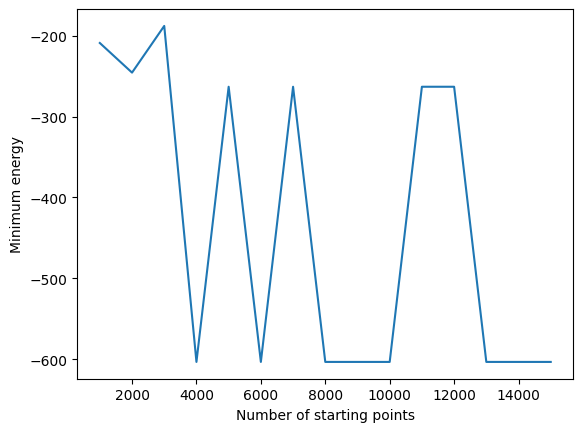

In [21]:
import matplotlib.pyplot as plt

plt.plot(n_points, min_E)
plt.xlabel('Number of starting points')
plt.ylabel('Minimum energy')
plt.show()

Extra gaussian test

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def fit_gaussian_process(input_array):
    """
    Fit a Gaussian Process model to the provided n-dimensional array.

    Args:
    - input_array (np.ndarray): The n-dimensional array where the first row contains energy (z-values)
                                and the subsequent rows represent the coordinates in n-dimensional space.

    Returns:
    - gp (GaussianProcessRegressor): The trained Gaussian Process model.
    """
    # Separate the energy (first row) and location data (other rows)
    energy_values = input_array[0, :]  # Energy values (z)
    location_data = input_array[1:, :].T  # Location data (x, y, ...)

    # Define the kernel: we use a product of constant kernel and RBF kernel (Gaussian kernel)
    kernel = C(1.0, (1e-4, 1e2)) * RBF(1.0, (1e-4, 1e2))  # Constant * RBF kernel

    # Initialize the GaussianProcessRegressor with the kernel
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    # Fit the GP model to the data
    gp.fit(location_data, energy_values)

    return gp

def predict_energy(gp, location):
    """
    Predict the energy at a given location using the fitted Gaussian Process model.

    Args:
    - gp (GaussianProcessRegressor): The trained Gaussian Process model.
    - location (np.ndarray): The location for which to predict the energy.

    Returns:
    - energy (float): The predicted energy at the given location.
    """
    # Ensure the location is in the right shape (1 x n_dim)
    location = np.array(location).reshape(1, -1)

    # Use the Gaussian Process model to predict the energy at the specified location
    energy, _ = gp.predict(location, return_std=True)

    return energy[0]  # Return the predicted energy value

# Example Usage:
# Input: An example n-dimensional array where the first row is energy, and others are coordinates.
input_array = np.array([
    [1.0, 2.0, 3.0, 4.0],  # Energy (z-values)
    [0.0, 1.0, 2.0, 3.0],  # Location 1 (x)
    [1.0, 1.5, 2.0, 2.5],  # Location 2 (y)
])

# Fit the Gaussian Process model to the input data
gp_model2 = fit_gaussian_process(matrix.T)

# Predict the energy at a new location (e.g., at location [2.5, 2.0])
new_location = [12.53040961,-0.35355502,0.77559776,0,3.25126297,-0.71151855,0,0,31.57864638]

predicted_energy = predict_energy(gp_model2, new_location)

# Output the predicted energy
print(f"Predicted energy at location {new_location}: {predicted_energy}")


Predicted energy at location [12.53040961, -0.35355502, 0.77559776, 0, 3.25126297, -0.71151855, 0, 0, 31.57864638]: -571.6800185239982


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
# Example objective function using GP
def gp_objective_function(location):
    return predict_energy(gp_model2, location)

# Define the bounds for 9 dimensions (example: [0, 1] for each dimension)
n_dim = 9
#bounds = np.tile([0, 1], (n_dim, 1))

# Create the AFSA object
afsa = ArtificialFishSwarm(
    objective_function=gp_objective_function,
    n_dim=n_dim,
    bounds=bounds,
    population_size=1000,
    max_iter=50,
    step_size=2,
    visual_range=2
)

# Run the AFSA algorithm
best_solution, best_fitness = afsa.run()

# Output the results
print("\nGlobal Minimum Location:", best_solution)
print("Global Minimum Energy:", best_fitness)


Iteration 1: Best Fitness = -7.590038714127608
